## Functions to grab features from a directory

In [ ]:
import os
import numpy as np

def feature_from_file(file_path, feature_type="head", byte_num=512): # will add more feature_type later
    """Retreives features from a file.
  
    Parameters:
    feature_type (str): "head" to get bytes from head of the file.
    byte_num (int): Number of bytes to grab.
    file_path (str): File path of file to get features from.
    
    Returns:
    List of bytes from file_path. 
    """
    with open(file_path, 'rb') as f:
        byte = f.read(1)
        index = 1
        features = []
    
        while byte and index <= byte_num:
            features.append(byte)
            index += 1
            byte = f.read(1)
        
        if len(features) < byte_num:
            features.extend([b'' for i in range(byte_num - len(features))])

        assert len(features) == byte_num
        return features

def feature_from_dir(dir_path, feature_type="head", byte_num=512):
    """Takes a directory and grabs features from each file.
    
    Parameters:
    dir_path (str): Path of directory to take features from.
    feature_type (str): Type of features to get.
    byte_num (str): Number of features to take
    
    Return:
    features (list): List containing a list of byte_num bytes from each fie in dir_path.
    """
    features = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        for filename in filenames:
            features.append(feature_from_file(os.path.join(dirpath, filename), feature_type, byte_num))
    
    return features

def translate_bytes(dir_features):
    """Translates bytes into integers.
    
    Parameter:
    dir_features (list): List containing lists of bytes.
    
    Return:
    translated_features (numpy array): dir_features with bytes translated to integers.
    """
    translated_features = np.zeros((len(dir_features), len(dir_features[0])))
    
    for idx, file_features in enumerate(dir_features):
        translated_features[idx] = np.array([int.from_bytes(c, byteorder="big") for c in file_features])
    
    return translated_features

## Feature preprocessing

In [31]:
from sklearn.model_selection import train_test_split

test_set_dir = '/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8'
x = translate_bytes(feature_from_dir(test_set_dir, byte_num=1024))
#x = x / 255

x_train, x_test, _, _ = train_test_split(x, x)

## Keras model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

encoder = Model(input_layer, encoded)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_80 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_83 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_84 (Dense)             (None, 1024)              263168    
Total para

15321/15321 [==============================] - 1s 63us/step - loss: 371615.1666 - acc: 0.0931 - val_loss: 370191.2100 - val_acc: 0.0956
Epoch 48/100
15321/15321 [==============================] - 1s 64us/step - loss: 371667.2984 - acc: 0.0870 - val_loss: 370091.5080 - val_acc: 0.0909
Epoch 49/100
15321/15321 [==============================] - 1s 64us/step - loss: 371545.1701 - acc: 0.0740 - val_loss: 370231.4568 - val_acc: 0.0936
Epoch 50/100
15321/15321 [==============================] - 1s 63us/step - loss: 371555.3672 - acc: 0.0815 - val_loss: 370058.7412 - val_acc: 0.0783
Epoch 51/100
15321/15321 [==============================] - 1s 64us/step - loss: 371645.7600 - acc: 0.0732 - val_loss: 370075.2185 - val_acc: 0.0726
Epoch 52/100
15321/15321 [==============================] - 1s 64us/step - loss: 371470.2088 - acc: 0.0745 - val_loss: 370001.7938 - val_acc: 0.0824
Epoch 53/100
15321/15321 [==============================] - 1s 64us/step - loss: 371514.9731 - acc: 0.0728 - val_loss: 

## Results visualization

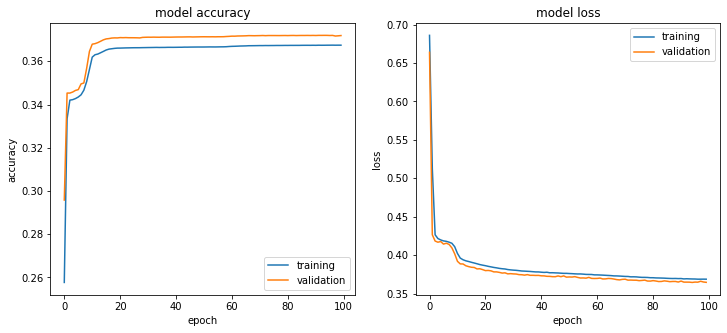

In [30]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)